Import the relevent libraries
Pandas package for loading and preprocessing the dataset

In [83]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import svm
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils

Read the training dateset

In [84]:
#ALso remember to parse the date column. This will be helpful in the next step
training_data=pd.read_csv('Arundo_take_home_challenge_training_set.csv',sep=',',parse_dates=['date'])
#Have a look at the data
training_data.head()

,date,calendar_code,request_count,site_count,max_temp,min_temp,precipitation,events
0,2014-09-01,0.0,165,6,30.6,22.8,0.0,Rain
1,2014-09-02,1.0,138,7,32.8,22.8,15.5,Rain-Thunderstorm
2,2014-09-03,1.0,127,7,29.4,18.3,0.0,None
3,2014-09-04,1.0,174,7,29.4,17.2,0.0,None
4,2014-09-05,1.0,196,7,30.6,21.7,0.0,Fog


Let us try to get a better insight into the data. First let us have a look at the dependence of request counts on the float variables.

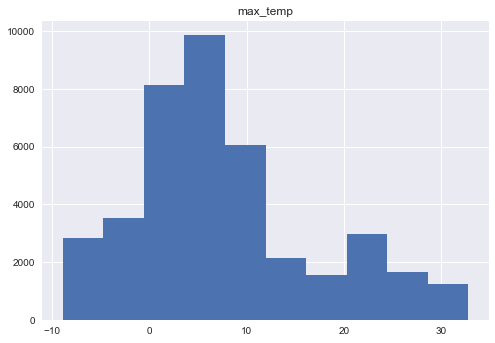

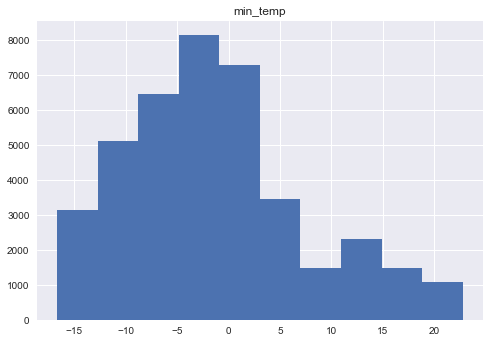

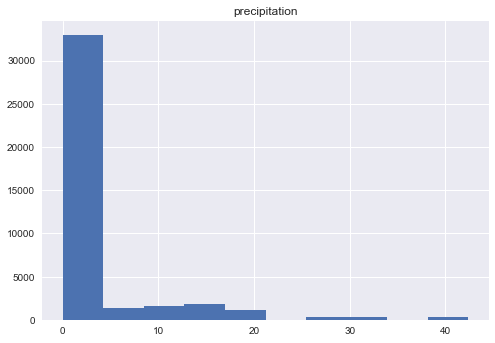

In [85]:
training_data.hist('max_temp',weights=training_data['request_count'])
training_data.hist('min_temp',weights=training_data['request_count'])
training_data.hist('precipitation',weights=training_data['request_count'])
plt.show()

From the above histograms we see that most of the request comes when 1). maximum temperature is below 10C 2). min temperature is below 2C 3) When there is zero precipitation 

We use violin plot for dependence on the categorical variables (https://blog.modeanalytics.com/violin-plot-examples/)

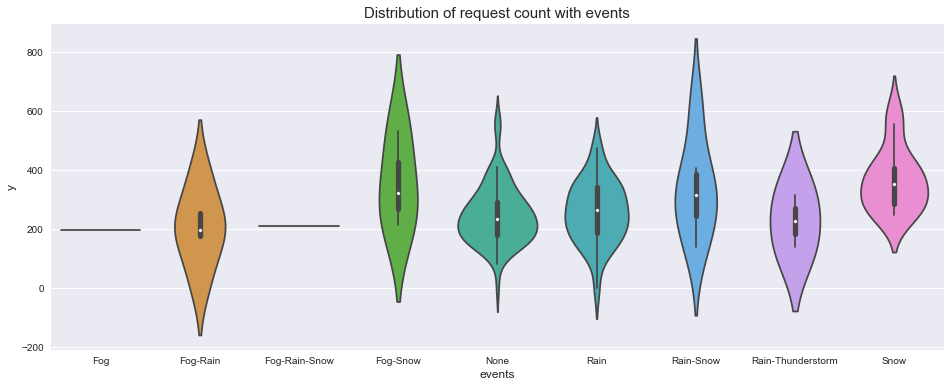

In [86]:
var_name = "events"
col_order = np.sort(training_data[var_name].unique()).tolist()
plt.figure(figsize=(16,6))
sns.violinplot(x=var_name, y='request_count', data=training_data, order=col_order)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of request count with "+var_name, fontsize=15)
plt.show()

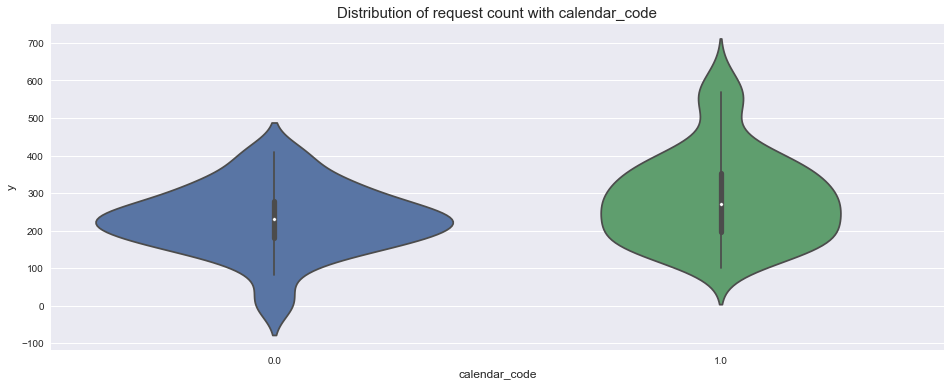

In [87]:
var_name = "calendar_code"
col_order = np.sort(training_data[var_name].unique()).tolist()
plt.figure(figsize=(16,6))
sns.violinplot(x=var_name, y='request_count', data=training_data, order=col_order)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of request count with "+var_name, fontsize=15)
plt.show()

The date as such is not as important. May be the site maintenence is dependant on the working day or weekend. We add an additional column with the week day (0: Monday, ... 6: Sunday)

In [88]:
training_data['day_of_week'] = training_data['date'].dt.dayofweek
training_data['week_day'] = training_data['date'].dt.weekday_name
training_data.head()

,date,calendar_code,request_count,site_count,max_temp,min_temp,precipitation,events,day_of_week,week_day
0,2014-09-01,0.0,165,6,30.6,22.8,0.0,Rain,0,Monday
1,2014-09-02,1.0,138,7,32.8,22.8,15.5,Rain-Thunderstorm,1,Tuesday
2,2014-09-03,1.0,127,7,29.4,18.3,0.0,None,2,Wednesday
3,2014-09-04,1.0,174,7,29.4,17.2,0.0,None,3,Thursday
4,2014-09-05,1.0,196,7,30.6,21.7,0.0,Fog,4,Friday


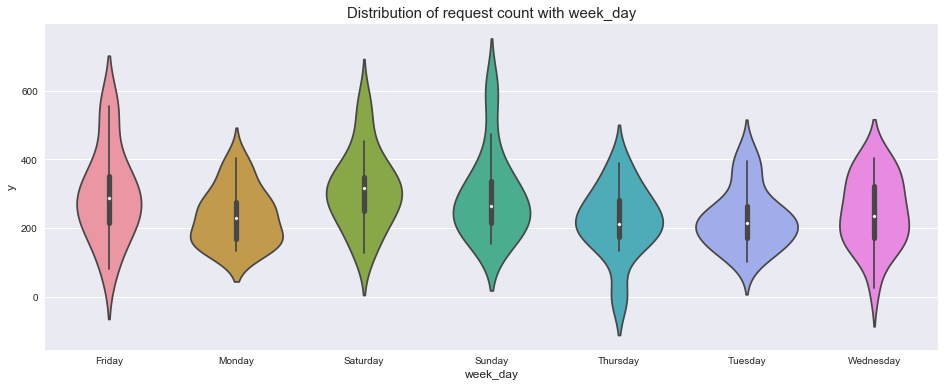

In [89]:
var_name = "week_day"
col_order = np.sort(training_data[var_name].unique()).tolist()
plt.figure(figsize=(16,6))
sns.violinplot(x=var_name, y='request_count', data=training_data, order=col_order)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of request count with "+var_name, fontsize=15)
plt.show()

Next we convert the events into some unique identifiers (integers). This will result in an additional column "events_code"

In [90]:
training_data['events_code'] = pd.Categorical(training_data["events"]).codes
training_data.head()

,date,calendar_code,request_count,site_count,max_temp,min_temp,precipitation,events,day_of_week,week_day,events_code
0,2014-09-01,0.0,165,6,30.6,22.8,0.0,Rain,0,Monday,5
1,2014-09-02,1.0,138,7,32.8,22.8,15.5,Rain-Thunderstorm,1,Tuesday,7
2,2014-09-03,1.0,127,7,29.4,18.3,0.0,None,2,Wednesday,4
3,2014-09-04,1.0,174,7,29.4,17.2,0.0,None,3,Thursday,4
4,2014-09-05,1.0,196,7,30.6,21.7,0.0,Fog,4,Friday,0


Since request count is the target variable, we store it separately as "y"

In [91]:
y=training_data["request_count"]
print("Shape of y ",y.shape)

Shape of y  (152,)


Drop the redundant columns now "date","events","request_count"

In [92]:
training_data = training_data.drop(["date","events","request_count","week_day"],axis=1)
training_data.head()

,calendar_code,site_count,max_temp,min_temp,precipitation,day_of_week,events_code
0,0.0,6,30.6,22.8,0.0,0,5
1,1.0,7,32.8,22.8,15.5,1,7
2,1.0,7,29.4,18.3,0.0,2,4
3,1.0,7,29.4,17.2,0.0,3,4
4,1.0,7,30.6,21.7,0.0,4,0


The categorical values day_of_week, events_code and calender code needs to be one-hot-encoded to be used as a feature input vector. 

In [93]:
training_data= pd.get_dummies(training_data,columns=["calendar_code","events_code","day_of_week"],prefix=["calendar","event","week"])
training_data.head()

,site_count,max_temp,min_temp,precipitation,calendar_0.0,calendar_1.0,event_0,event_1,event_2,event_3,...,event_6,event_7,event_8,week_0,week_1,week_2,week_3,week_4,week_5,week_6
0,6,30.6,22.8,0.0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,7,32.8,22.8,15.5,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
2,7,29.4,18.3,0.0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,7,29.4,17.2,0.0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,7,30.6,21.7,0.0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Call the feature vectors X

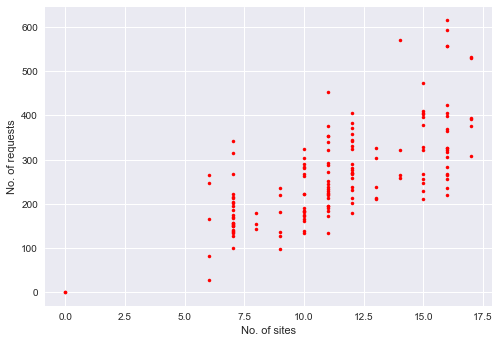

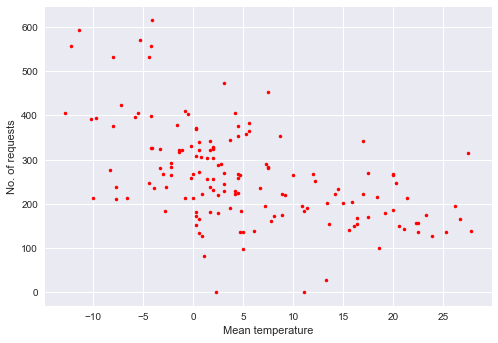

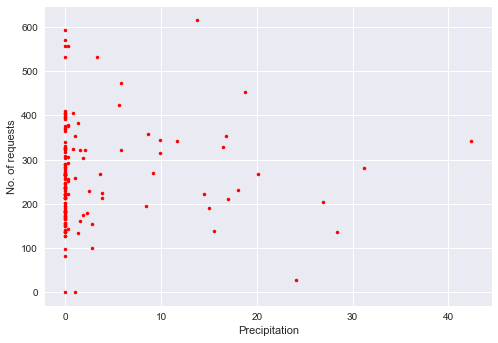

In [94]:
X=training_data.values

plt.figure(1)
plt.plot(X[:,0],y[:],'r.')
plt.xlabel("No. of sites")
plt.ylabel("No. of requests")
plt.show()

plt.figure(1)
plt.plot((X[:,1]+X[:,2])/2.0,y[:],'r.')
plt.xlabel("Mean temperature")
plt.ylabel("No. of requests")
plt.show()

plt.figure(1)
plt.plot(X[:,3],y[:],'r.')
plt.xlabel("Precipitation")
plt.ylabel("No. of requests")
plt.show()

It appeats that the no of requests has some kind of a quadratic dependence on the mean temperature so in addition to max and min temperature we should construct a new feature ((minx+maxx)/2)^2

In [95]:
X=np.column_stack([X,(X[:,1]+X[:,2])**2.0])

In [96]:
#Split the data into training and validation test
X_train, X_val, y_train, y_val =  train_test_split(X,y,test_size=0.2,random_state = 0)

Conduct a multivariate linear regression on the dataset.

In [97]:
#Multivariabte regression
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_train_pred=regr.predict(X_train)
print("Mean squared error: %.2f" % np.mean((regr.predict(X_train) - y_train) ** 2))
print("Mean squared error: %.2f" % np.mean((regr.predict(X_val) - y_val) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_train, y_train))
print('Variance score: %.2f' % regr.score(X_val, y_val))

Mean squared error: 2050.26
Mean squared error: 3354.57
Variance score: 0.82
Variance score: 0.77


In [103]:
pred_LR = regr.predict(X_val)
y_val = y_val.reshape(-1,1)
for i in range(len(pred)):
    print(pred_LR[i],y_val[i])

238.034675893 [214]
319.680588489 [322]
298.20747587 [383]
210.606509338 [203]
233.435611564 [232]
284.532018821 [268]
92.0504257959 [27]
158.220910418 [150]
360.04546281 [322]
307.729653896 [339]
165.883823091 [183]
353.663204344 [406]
339.068823498 [318]
202.445832986 [267]
213.484634594 [281]
409.558669316 [570]
306.445742376 [343]
207.30683584 [202]
223.757677269 [229]
99.4213477369 [234]
536.882495537 [593]
292.053770194 [344]
299.039183423 [410]
479.788242363 [531]
238.681242899 [327]
259.636307388 [290]
144.667759171 [171]
324.155414033 [321]
327.174144767 [304]
155.127868625 [180]
155.740139511 [137]


Neural Network

In [98]:
m,input_layer_size=X.shape
hidden_layer_size = input_layer_size   
ANN_classifier = Sequential()
ANN_classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu', input_dim = input_layer_size))
ANN_classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu'))
ANN_classifier.add(Dense(units = 1, kernel_initializer = 'normal'))
ANN_classifier.compile(loss='mean_squared_error', optimizer='adam')
history=ANN_classifier.fit(X_train, y_train, batch_size = 15, epochs = 4000,verbose=1)

Epoch 1/4000
121/121 [==============================] - 0s - loss: 76510.9477     
Epoch 2/4000
121/121 [==============================] - 0s - loss: 76458.7137     
Epoch 3/4000
121/121 [==============================] - 0s - loss: 76399.4176     
Epoch 4/4000
121/121 [==============================] - 0s - loss: 76315.2315     
Epoch 5/4000
121/121 [==============================] - 0s - loss: 76114.3418     
Epoch 6/4000
121/121 [==============================] - 0s - loss: 75698.2392     
Epoch 7/4000
121/121 [==============================] - 0s - loss: 75004.5795     
Epoch 8/4000
121/121 [==============================] - 0s - loss: 73974.1031     
Epoch 9/4000
121/121 [==============================] - 0s - loss: 72392.6299     
Epoch 10/4000
121/121 [==============================] - 0s - loss: 70552.5208     
Epoch 11/4000
121/121 [==============================] - 0s - loss: 68309.9833     
Epoch 12/4000
121/121 [==============================] - 0s - loss: 66169.2089     
E

121/121 [==============================] - 0s - loss: 24419.6902     
Epoch 98/4000
121/121 [==============================] - 0s - loss: 23087.4883     
Epoch 99/4000
121/121 [==============================] - 0s - loss: 22204.9479     
Epoch 100/4000
121/121 [==============================] - 0s - loss: 21137.3256     
Epoch 101/4000
121/121 [==============================] - 0s - loss: 19926.8466     
Epoch 102/4000
121/121 [==============================] - 0s - loss: 18931.0080     
Epoch 103/4000
121/121 [==============================] - 0s - loss: 17821.3033     
Epoch 104/4000
121/121 [==============================] - 0s - loss: 16845.4285     
Epoch 105/4000
121/121 [==============================] - 0s - loss: 15793.7399     
Epoch 106/4000
121/121 [==============================] - 0s - loss: 14844.3917    
Epoch 107/4000
121/121 [==============================] - 0s - loss: 14168.9822    
Epoch 108/4000
121/121 [==============================] - 0s - loss: 13478.3547    


121/121 [==============================] - 0s - loss: 6600.4761     
Epoch 194/4000
121/121 [==============================] - 0s - loss: 6591.3484     
Epoch 195/4000
121/121 [==============================] - 0s - loss: 6573.5086     
Epoch 196/4000
121/121 [==============================] - 0s - loss: 6628.8560     
Epoch 197/4000
121/121 [==============================] - 0s - loss: 6606.4177     
Epoch 198/4000
121/121 [==============================] - 0s - loss: 6555.1408     
Epoch 199/4000
121/121 [==============================] - 0s - loss: 6541.6511      
Epoch 200/4000
121/121 [==============================] - 0s - loss: 7196.4175     
Epoch 201/4000
121/121 [==============================] - 0s - loss: 7277.5449     
Epoch 202/4000
121/121 [==============================] - 0s - loss: 6798.7095      
Epoch 203/4000
121/121 [==============================] - 0s - loss: 6613.1003     
Epoch 204/4000
121/121 [==============================] - 0s - loss: 6530.0976     
Epoch

121/121 [==============================] - 0s - loss: 5865.8574     
Epoch 290/4000
121/121 [==============================] - 0s - loss: 5807.1118     
Epoch 291/4000
121/121 [==============================] - 0s - loss: 5802.8197     
Epoch 292/4000
121/121 [==============================] - 0s - loss: 5793.6355     
Epoch 293/4000
121/121 [==============================] - 0s - loss: 5803.6006     
Epoch 294/4000
121/121 [==============================] - 0s - loss: 5792.4368     
Epoch 295/4000
121/121 [==============================] - 0s - loss: 5770.8838     
Epoch 296/4000
121/121 [==============================] - 0s - loss: 5825.7449     
Epoch 297/4000
121/121 [==============================] - 0s - loss: 5748.7688     
Epoch 298/4000
121/121 [==============================] - 0s - loss: 5751.9840     
Epoch 299/4000
121/121 [==============================] - 0s - loss: 5781.4421     
Epoch 300/4000
121/121 [==============================] - 0s - loss: 5734.2866     
Epoch 3

121/121 [==============================] - 0s - loss: 5160.3398     
Epoch 387/4000
121/121 [==============================] - 0s - loss: 5148.9536     
Epoch 388/4000
121/121 [==============================] - 0s - loss: 5117.2363     
Epoch 389/4000
121/121 [==============================] - 0s - loss: 5106.3333     
Epoch 390/4000
121/121 [==============================] - 0s - loss: 5091.6758     
Epoch 391/4000
121/121 [==============================] - 0s - loss: 5096.6115     
Epoch 392/4000
121/121 [==============================] - 0s - loss: 5095.9359     
Epoch 393/4000
121/121 [==============================] - 0s - loss: 5069.5622     
Epoch 394/4000
121/121 [==============================] - 0s - loss: 5035.6978     
Epoch 395/4000
121/121 [==============================] - 0s - loss: 5658.3599     
Epoch 396/4000
121/121 [==============================] - 0s - loss: 5683.6496     
Epoch 397/4000
121/121 [==============================] - 0s - loss: 5209.5320     
Epoch 3

121/121 [==============================] - 0s - loss: 4462.1852     
Epoch 484/4000
121/121 [==============================] - 0s - loss: 4470.1532     
Epoch 485/4000
121/121 [==============================] - 0s - loss: 4471.0952     
Epoch 486/4000
121/121 [==============================] - 0s - loss: 4445.0804     
Epoch 487/4000
121/121 [==============================] - 0s - loss: 4470.4985     
Epoch 488/4000
121/121 [==============================] - 0s - loss: 4490.4997     
Epoch 489/4000
121/121 [==============================] - 0s - loss: 4446.8159     
Epoch 490/4000
121/121 [==============================] - 0s - loss: 4437.2683     
Epoch 491/4000
121/121 [==============================] - 0s - loss: 4426.6791     
Epoch 492/4000
121/121 [==============================] - 0s - loss: 4413.3526     
Epoch 493/4000
121/121 [==============================] - 0s - loss: 4408.8135     
Epoch 494/4000
121/121 [==============================] - 0s - loss: 4494.4542     
Epoch 4

121/121 [==============================] - 0s - loss: 3975.7279     
Epoch 581/4000
121/121 [==============================] - 0s - loss: 3981.6940     
Epoch 582/4000
121/121 [==============================] - 0s - loss: 3954.7344     
Epoch 583/4000
121/121 [==============================] - 0s - loss: 3921.9388     
Epoch 584/4000
121/121 [==============================] - 0s - loss: 3922.6583     
Epoch 585/4000
121/121 [==============================] - 0s - loss: 3910.0753     
Epoch 586/4000
121/121 [==============================] - 0s - loss: 3894.9908     
Epoch 587/4000
121/121 [==============================] - 0s - loss: 3929.5057     
Epoch 588/4000
121/121 [==============================] - 0s - loss: 3876.5689     
Epoch 589/4000
121/121 [==============================] - 0s - loss: 3890.4436     
Epoch 590/4000
121/121 [==============================] - 0s - loss: 3873.1176     
Epoch 591/4000
121/121 [==============================] - 0s - loss: 3893.9512     
Epoch 5

121/121 [==============================] - 0s - loss: 3497.5683     
Epoch 678/4000
121/121 [==============================] - 0s - loss: 3476.6608     
Epoch 679/4000
121/121 [==============================] - 0s - loss: 3462.9024     
Epoch 680/4000
121/121 [==============================] - 0s - loss: 3660.0551     
Epoch 681/4000
121/121 [==============================] - 0s - loss: 3513.3470     
Epoch 682/4000
121/121 [==============================] - 0s - loss: 3494.0428     
Epoch 683/4000
121/121 [==============================] - 0s - loss: 3480.6652     
Epoch 684/4000
121/121 [==============================] - 0s - loss: 3434.8542     
Epoch 685/4000
121/121 [==============================] - 0s - loss: 3446.2373     
Epoch 686/4000
121/121 [==============================] - 0s - loss: 3466.3679     
Epoch 687/4000
121/121 [==============================] - 0s - loss: 3441.6392     
Epoch 688/4000
121/121 [==============================] - 0s - loss: 3432.1622     
Epoch 6

121/121 [==============================] - 0s - loss: 3673.0825     
Epoch 775/4000
121/121 [==============================] - 0s - loss: 3802.3265     
Epoch 776/4000
121/121 [==============================] - 0s - loss: 3152.3905     
Epoch 777/4000
121/121 [==============================] - 0s - loss: 3331.9676     
Epoch 778/4000
121/121 [==============================] - 0s - loss: 3159.1859     
Epoch 779/4000
121/121 [==============================] - 0s - loss: 3126.4041     
Epoch 780/4000
121/121 [==============================] - 0s - loss: 3134.4139     
Epoch 781/4000
121/121 [==============================] - 0s - loss: 3101.4367     
Epoch 782/4000
121/121 [==============================] - 0s - loss: 3088.0851     
Epoch 783/4000
121/121 [==============================] - 0s - loss: 3109.1266     
Epoch 784/4000
121/121 [==============================] - 0s - loss: 3107.7268     
Epoch 785/4000
121/121 [==============================] - 0s - loss: 3131.6354     
Epoch 7

121/121 [==============================] - 0s - loss: 2841.4055     
Epoch 872/4000
121/121 [==============================] - 0s - loss: 2827.6524     
Epoch 873/4000
121/121 [==============================] - 0s - loss: 2831.5199     
Epoch 874/4000
121/121 [==============================] - 0s - loss: 2807.3808     
Epoch 875/4000
121/121 [==============================] - 0s - loss: 2835.3734     
Epoch 876/4000
121/121 [==============================] - 0s - loss: 2852.6052     
Epoch 877/4000
121/121 [==============================] - 0s - loss: 2837.3269     
Epoch 878/4000
121/121 [==============================] - 0s - loss: 2812.7637     
Epoch 879/4000
121/121 [==============================] - 0s - loss: 2817.4840     
Epoch 880/4000
121/121 [==============================] - 0s - loss: 2801.7620     
Epoch 881/4000
121/121 [==============================] - 0s - loss: 2810.5392     
Epoch 882/4000
121/121 [==============================] - 0s - loss: 2795.6901     
Epoch 8

121/121 [==============================] - 0s - loss: 3471.1872     
Epoch 969/4000
121/121 [==============================] - 0s - loss: 2630.8145     
Epoch 970/4000
121/121 [==============================] - 0s - loss: 2839.7383     
Epoch 971/4000
121/121 [==============================] - 0s - loss: 2853.7473     
Epoch 972/4000
121/121 [==============================] - 0s - loss: 2686.7412     
Epoch 973/4000
121/121 [==============================] - 0s - loss: 2668.6269     
Epoch 974/4000
121/121 [==============================] - 0s - loss: 2622.0836     
Epoch 975/4000
121/121 [==============================] - 0s - loss: 2623.3705     
Epoch 976/4000
121/121 [==============================] - 0s - loss: 2625.3096     
Epoch 977/4000
121/121 [==============================] - 0s - loss: 2622.5490     
Epoch 978/4000
121/121 [==============================] - ETA: 0s - loss: 5935.10 - 0s - loss: 2620.8290     
Epoch 979/4000
121/121 [==============================] - 0s - lo

121/121 [==============================] - 0s - loss: 2514.3425     
Epoch 1065/4000
121/121 [==============================] - 0s - loss: 2519.4499     
Epoch 1066/4000
121/121 [==============================] - 0s - loss: 2514.6780     
Epoch 1067/4000
121/121 [==============================] - 0s - loss: 2553.6611     
Epoch 1068/4000
121/121 [==============================] - 0s - loss: 2528.6222     
Epoch 1069/4000
121/121 [==============================] - 0s - loss: 2542.9533     
Epoch 1070/4000
121/121 [==============================] - 0s - loss: 2536.9048     
Epoch 1071/4000
121/121 [==============================] - 0s - loss: 2509.9434     
Epoch 1072/4000
121/121 [==============================] - 0s - loss: 2514.7546     
Epoch 1073/4000
121/121 [==============================] - 0s - loss: 2513.9575     
Epoch 1074/4000
121/121 [==============================] - 0s - loss: 2503.1473     
Epoch 1075/4000
121/121 [==============================] - 0s - loss: 2502.8178  

121/121 [==============================] - 0s - loss: 2465.4235     
Epoch 1161/4000
121/121 [==============================] - 0s - loss: 2459.7327     
Epoch 1162/4000
121/121 [==============================] - 0s - loss: 2468.7154     
Epoch 1163/4000
121/121 [==============================] - 0s - loss: 2470.4290     
Epoch 1164/4000
121/121 [==============================] - 0s - loss: 2489.1949    
Epoch 1165/4000
121/121 [==============================] - 0s - loss: 2453.9979     
Epoch 1166/4000
121/121 [==============================] - 0s - loss: 2436.9136     
Epoch 1167/4000
121/121 [==============================] - 0s - loss: 2437.6246     
Epoch 1168/4000
121/121 [==============================] - 0s - loss: 2427.6690    
Epoch 1169/4000
121/121 [==============================] - 0s - loss: 2441.6407     
Epoch 1170/4000
121/121 [==============================] - 0s - loss: 2450.5123     
Epoch 1171/4000
121/121 [==============================] - 0s - loss: 2433.3055    

121/121 [==============================] - 0s - loss: 2382.1195     
Epoch 1257/4000
121/121 [==============================] - 0s - loss: 2390.1210     
Epoch 1258/4000
121/121 [==============================] - 0s - loss: 2377.3945     
Epoch 1259/4000
121/121 [==============================] - 0s - loss: 2423.2181     
Epoch 1260/4000
121/121 [==============================] - 0s - loss: 2487.2873     
Epoch 1261/4000
121/121 [==============================] - 0s - loss: 2662.7706     
Epoch 1262/4000
121/121 [==============================] - 0s - loss: 2851.8401     
Epoch 1263/4000
121/121 [==============================] - 0s - loss: 2490.5681     
Epoch 1264/4000
121/121 [==============================] - 0s - loss: 2418.2384     
Epoch 1265/4000
121/121 [==============================] - 0s - loss: 2390.1887     
Epoch 1266/4000
121/121 [==============================] - 0s - loss: 2370.3391    
Epoch 1267/4000
121/121 [==============================] - 0s - loss: 2385.8696   

121/121 [==============================] - 0s - loss: 2330.3349     
Epoch 1353/4000
121/121 [==============================] - 0s - loss: 2334.1137    
Epoch 1354/4000
121/121 [==============================] - 0s - loss: 2427.5348     
Epoch 1355/4000
121/121 [==============================] - 0s - loss: 2380.9953     
Epoch 1356/4000
121/121 [==============================] - 0s - loss: 2352.7892     
Epoch 1357/4000
121/121 [==============================] - 0s - loss: 2732.4820     
Epoch 1358/4000
121/121 [==============================] - 0s - loss: 2408.8123     
Epoch 1359/4000
121/121 [==============================] - 0s - loss: 2390.3627     
Epoch 1360/4000
121/121 [==============================] - 0s - loss: 2326.1845     
Epoch 1361/4000
121/121 [==============================] - 0s - loss: 2323.2352     
Epoch 1362/4000
121/121 [==============================] - 0s - loss: 2529.1790    
Epoch 1363/4000
121/121 [==============================] - 0s - loss: 2440.9777    

121/121 [==============================] - 0s - loss: 2322.3749     
Epoch 1449/4000
121/121 [==============================] - 0s - loss: 2300.5913     
Epoch 1450/4000
121/121 [==============================] - 0s - loss: 2325.4353     
Epoch 1451/4000
121/121 [==============================] - 0s - loss: 2292.1826     
Epoch 1452/4000
121/121 [==============================] - 0s - loss: 2299.7803     
Epoch 1453/4000
121/121 [==============================] - 0s - loss: 2273.1898    
Epoch 1454/4000
121/121 [==============================] - 0s - loss: 2293.2181     
Epoch 1455/4000
121/121 [==============================] - 0s - loss: 2299.9961     
Epoch 1456/4000
121/121 [==============================] - 0s - loss: 2288.1413     
Epoch 1457/4000
121/121 [==============================] - 0s - loss: 2330.4539     
Epoch 1458/4000
121/121 [==============================] - 0s - loss: 2335.0976     
Epoch 1459/4000
121/121 [==============================] - 0s - loss: 2403.7967   

121/121 [==============================] - 0s - loss: 2358.2020     
Epoch 1545/4000
121/121 [==============================] - 0s - loss: 2352.5850     
Epoch 1546/4000
121/121 [==============================] - 0s - loss: 2269.8247     
Epoch 1547/4000
121/121 [==============================] - 0s - loss: 2285.1711     
Epoch 1548/4000
121/121 [==============================] - 0s - loss: 2299.0272     
Epoch 1549/4000
121/121 [==============================] - 0s - loss: 2581.9681     
Epoch 1550/4000
121/121 [==============================] - 0s - loss: 2381.2493     
Epoch 1551/4000
121/121 [==============================] - 0s - loss: 2282.8821     
Epoch 1552/4000
121/121 [==============================] - 0s - loss: 2323.9739     
Epoch 1553/4000
121/121 [==============================] - 0s - loss: 2355.3381     
Epoch 1554/4000
121/121 [==============================] - 0s - loss: 2395.7473     
Epoch 1555/4000
121/121 [==============================] - 0s - loss: 2331.9121  

121/121 [==============================] - 0s - loss: 2242.5004     
Epoch 1641/4000
121/121 [==============================] - 0s - loss: 2250.2171     
Epoch 1642/4000
121/121 [==============================] - 0s - loss: 2251.5059     
Epoch 1643/4000
121/121 [==============================] - 0s - loss: 2229.0194     
Epoch 1644/4000
121/121 [==============================] - 0s - loss: 2245.0227     
Epoch 1645/4000
121/121 [==============================] - 0s - loss: 2232.6076     
Epoch 1646/4000
121/121 [==============================] - 0s - loss: 2246.8968     
Epoch 1647/4000
121/121 [==============================] - 0s - loss: 2237.7336     
Epoch 1648/4000
121/121 [==============================] - 0s - loss: 2272.3141     
Epoch 1649/4000
121/121 [==============================] - 0s - loss: 2259.7386     
Epoch 1650/4000
121/121 [==============================] - 0s - loss: 2255.1052     
Epoch 1651/4000
121/121 [==============================] - 0s - loss: 2298.5219  

121/121 [==============================] - 0s - loss: 2205.0923     
Epoch 1737/4000
121/121 [==============================] - 0s - loss: 2263.6129     
Epoch 1738/4000
121/121 [==============================] - 0s - loss: 2259.1090     
Epoch 1739/4000
121/121 [==============================] - 0s - loss: 2211.7281     
Epoch 1740/4000
121/121 [==============================] - 0s - loss: 2239.5988     
Epoch 1741/4000
121/121 [==============================] - 0s - loss: 2285.8752     
Epoch 1742/4000
121/121 [==============================] - 0s - loss: 2294.8391     
Epoch 1743/4000
121/121 [==============================] - 0s - loss: 2231.1015     
Epoch 1744/4000
121/121 [==============================] - ETA: 0s - loss: 1600.22 - 0s - loss: 2202.5114     
Epoch 1745/4000
121/121 [==============================] - 0s - loss: 2196.0097     
Epoch 1746/4000
121/121 [==============================] - 0s - loss: 2207.7114     
Epoch 1747/4000
121/121 [==============================

121/121 [==============================] - 0s - loss: 2260.4331     
Epoch 1833/4000
121/121 [==============================] - 0s - loss: 2211.6464     
Epoch 1834/4000
121/121 [==============================] - 0s - loss: 2182.7703     
Epoch 1835/4000
121/121 [==============================] - 0s - loss: 2180.2643     
Epoch 1836/4000
121/121 [==============================] - 0s - loss: 2198.6026     
Epoch 1837/4000
121/121 [==============================] - 0s - loss: 2210.5370     
Epoch 1838/4000
121/121 [==============================] - 0s - loss: 2240.2941     
Epoch 1839/4000
121/121 [==============================] - 0s - loss: 2184.0433     
Epoch 1840/4000
121/121 [==============================] - 0s - loss: 2230.2356     
Epoch 1841/4000
121/121 [==============================] - 0s - loss: 2809.3414    
Epoch 1842/4000
121/121 [==============================] - 0s - loss: 2248.7162     
Epoch 1843/4000
121/121 [==============================] - 0s - loss: 2319.7678   

Epoch 1928/4000
121/121 [==============================] - 0s - loss: 2336.8775     
Epoch 1929/4000
121/121 [==============================] - 0s - loss: 2310.0963     
Epoch 1930/4000
121/121 [==============================] - 0s - loss: 2169.7369     
Epoch 1931/4000
121/121 [==============================] - 0s - loss: 2173.3323     
Epoch 1932/4000
121/121 [==============================] - 0s - loss: 2150.1249     
Epoch 1933/4000
121/121 [==============================] - 0s - loss: 2227.1042     
Epoch 1934/4000
121/121 [==============================] - 0s - loss: 2179.6941     
Epoch 1935/4000
121/121 [==============================] - 0s - loss: 2169.5280     
Epoch 1936/4000
121/121 [==============================] - 0s - loss: 2184.1985     
Epoch 1937/4000
121/121 [==============================] - 0s - loss: 2159.1260     
Epoch 1938/4000
121/121 [==============================] - 0s - loss: 2149.6605     
Epoch 1939/4000
121/121 [==============================] - 0s - l

121/121 [==============================] - 0s - loss: 2148.8297     
Epoch 2025/4000
121/121 [==============================] - 0s - loss: 2201.8647     
Epoch 2026/4000
121/121 [==============================] - 0s - loss: 2103.8050     
Epoch 2027/4000
121/121 [==============================] - 0s - loss: 2124.4543     
Epoch 2028/4000
121/121 [==============================] - 0s - loss: 2124.2511     
Epoch 2029/4000
121/121 [==============================] - 0s - loss: 2130.4333     
Epoch 2030/4000
121/121 [==============================] - 0s - loss: 2129.9235     
Epoch 2031/4000
121/121 [==============================] - 0s - loss: 2111.2790     
Epoch 2032/4000
121/121 [==============================] - 0s - loss: 2124.9742     
Epoch 2033/4000
121/121 [==============================] - 0s - loss: 2140.5864     
Epoch 2034/4000
121/121 [==============================] - 0s - loss: 2161.0012     
Epoch 2035/4000
121/121 [==============================] - 0s - loss: 2123.2971  

121/121 [==============================] - 0s - loss: 2120.4966     
Epoch 2121/4000
121/121 [==============================] - 0s - loss: 2114.0279     
Epoch 2122/4000
121/121 [==============================] - 0s - loss: 2107.7930     
Epoch 2123/4000
121/121 [==============================] - 0s - loss: 2119.2695     
Epoch 2124/4000
121/121 [==============================] - 0s - loss: 2279.0619     
Epoch 2125/4000
121/121 [==============================] - 0s - loss: 2254.1778     
Epoch 2126/4000
121/121 [==============================] - 0s - loss: 2170.6185     
Epoch 2127/4000
121/121 [==============================] - 0s - loss: 2156.2035     
Epoch 2128/4000
121/121 [==============================] - 0s - loss: 2140.1706     
Epoch 2129/4000
121/121 [==============================] - 0s - loss: 2120.3916     
Epoch 2130/4000
121/121 [==============================] - 0s - loss: 2098.8747     
Epoch 2131/4000
121/121 [==============================] - 0s - loss: 2141.5091  

121/121 [==============================] - 0s - loss: 2119.0154     
Epoch 2217/4000
121/121 [==============================] - 0s - loss: 2090.9831     
Epoch 2218/4000
121/121 [==============================] - 0s - loss: 2558.9723     
Epoch 2219/4000
121/121 [==============================] - 0s - loss: 2151.7355     
Epoch 2220/4000
121/121 [==============================] - 0s - loss: 2190.9515    
Epoch 2221/4000
121/121 [==============================] - 0s - loss: 2110.5384     
Epoch 2222/4000
121/121 [==============================] - 0s - loss: 2116.7370     
Epoch 2223/4000
121/121 [==============================] - 0s - loss: 2287.9830     
Epoch 2224/4000
121/121 [==============================] - 0s - loss: 2103.9044     
Epoch 2225/4000
121/121 [==============================] - 0s - loss: 2231.3487     
Epoch 2226/4000
121/121 [==============================] - 0s - loss: 2128.4815     
Epoch 2227/4000
121/121 [==============================] - 0s - loss: 2100.2788   

121/121 [==============================] - 0s - loss: 2123.1145     
Epoch 2312/4000
121/121 [==============================] - 0s - loss: 2082.6813     
Epoch 2313/4000
121/121 [==============================] - 0s - loss: 2100.1228     
Epoch 2314/4000
121/121 [==============================] - 0s - loss: 2091.6923     
Epoch 2315/4000
121/121 [==============================] - 0s - loss: 2136.5383     
Epoch 2316/4000
121/121 [==============================] - 0s - loss: 2107.0496     
Epoch 2317/4000
121/121 [==============================] - 0s - loss: 2131.5371     
Epoch 2318/4000
121/121 [==============================] - 0s - loss: 2102.3301     
Epoch 2319/4000
121/121 [==============================] - 0s - loss: 2085.8519     
Epoch 2320/4000
121/121 [==============================] - 0s - loss: 2080.9563     
Epoch 2321/4000
121/121 [==============================] - 0s - loss: 2067.1981     
Epoch 2322/4000
121/121 [==============================] - 0s - loss: 2084.4168  

121/121 [==============================] - 0s - loss: 2052.4058     
Epoch 2407/4000
121/121 [==============================] - 0s - loss: 2067.3826     
Epoch 2408/4000
121/121 [==============================] - 0s - loss: 2069.3662     
Epoch 2409/4000
121/121 [==============================] - 0s - loss: 2099.2460    
Epoch 2410/4000
121/121 [==============================] - 0s - loss: 2121.7962     
Epoch 2411/4000
121/121 [==============================] - 0s - loss: 2090.0663     
Epoch 2412/4000
121/121 [==============================] - 0s - loss: 2076.8588     
Epoch 2413/4000
121/121 [==============================] - 0s - loss: 2085.5576     
Epoch 2414/4000
121/121 [==============================] - 0s - loss: 2108.2697     
Epoch 2415/4000
121/121 [==============================] - 0s - loss: 2139.6449     
Epoch 2416/4000
121/121 [==============================] - 0s - loss: 2125.5604     
Epoch 2417/4000
121/121 [==============================] - 0s - loss: 2093.1837   

121/121 [==============================] - 0s - loss: 2475.9031     
Epoch 2503/4000
121/121 [==============================] - 0s - loss: 2521.1972     
Epoch 2504/4000
121/121 [==============================] - 0s - loss: 2217.4348     
Epoch 2505/4000
121/121 [==============================] - 0s - loss: 2171.5485     
Epoch 2506/4000
121/121 [==============================] - 0s - loss: 2160.8248     
Epoch 2507/4000
121/121 [==============================] - 0s - loss: 2058.5129     
Epoch 2508/4000
121/121 [==============================] - 0s - loss: 2085.7880     
Epoch 2509/4000
121/121 [==============================] - 0s - loss: 2063.3666     
Epoch 2510/4000
121/121 [==============================] - 0s - loss: 2291.9608     
Epoch 2511/4000
121/121 [==============================] - 0s - loss: 2191.5302     
Epoch 2512/4000
121/121 [==============================] - 0s - loss: 2129.8380     
Epoch 2513/4000
121/121 [==============================] - 0s - loss: 2067.2368  

121/121 [==============================] - 0s - loss: 2067.7085     
Epoch 2599/4000
121/121 [==============================] - 0s - loss: 2328.5405     
Epoch 2600/4000
121/121 [==============================] - 0s - loss: 2140.8670     
Epoch 2601/4000
121/121 [==============================] - 0s - loss: 2162.9629     
Epoch 2602/4000
121/121 [==============================] - 0s - loss: 2074.2240     
Epoch 2603/4000
121/121 [==============================] - 0s - loss: 2080.9221     
Epoch 2604/4000
121/121 [==============================] - 0s - loss: 2028.1179     
Epoch 2605/4000
121/121 [==============================] - 0s - loss: 2050.4310     
Epoch 2606/4000
121/121 [==============================] - 0s - loss: 2001.1542     
Epoch 2607/4000
121/121 [==============================] - 0s - loss: 2034.1202     
Epoch 2608/4000
121/121 [==============================] - 0s - loss: 2028.8444     
Epoch 2609/4000
121/121 [==============================] - 0s - loss: 2065.7396  

121/121 [==============================] - 0s - loss: 2017.6826     
Epoch 2695/4000
121/121 [==============================] - 0s - loss: 2024.7554     
Epoch 2696/4000
121/121 [==============================] - 0s - loss: 2051.8671     
Epoch 2697/4000
121/121 [==============================] - 0s - loss: 2029.1046     
Epoch 2698/4000
121/121 [==============================] - 0s - loss: 2029.8599     
Epoch 2699/4000
121/121 [==============================] - 0s - loss: 2047.4319     
Epoch 2700/4000
121/121 [==============================] - 0s - loss: 2068.5806     
Epoch 2701/4000
121/121 [==============================] - 0s - loss: 2037.8315     
Epoch 2702/4000
121/121 [==============================] - 0s - loss: 2109.8126     
Epoch 2703/4000
121/121 [==============================] - 0s - loss: 2036.3388    
Epoch 2704/4000
121/121 [==============================] - 0s - loss: 2071.0250     
Epoch 2705/4000
121/121 [==============================] - 0s - loss: 2028.9210   

121/121 [==============================] - 0s - loss: 2049.6145     
Epoch 2791/4000
121/121 [==============================] - 0s - loss: 2116.6217     
Epoch 2792/4000
121/121 [==============================] - 0s - loss: 2030.4529     
Epoch 2793/4000
121/121 [==============================] - 0s - loss: 2052.2025     
Epoch 2794/4000
121/121 [==============================] - 0s - loss: 2034.8763     
Epoch 2795/4000
121/121 [==============================] - 0s - loss: 1995.1068     
Epoch 2796/4000
121/121 [==============================] - 0s - loss: 2007.6354     
Epoch 2797/4000
121/121 [==============================] - 0s - loss: 2004.3847     
Epoch 2798/4000
121/121 [==============================] - 0s - loss: 2005.5940    
Epoch 2799/4000
121/121 [==============================] - 0s - loss: 2013.4981     
Epoch 2800/4000
121/121 [==============================] - 0s - loss: 2010.9040     
Epoch 2801/4000
121/121 [==============================] - 0s - loss: 2023.9576   

121/121 [==============================] - 0s - loss: 1997.6530     
Epoch 2887/4000
121/121 [==============================] - 0s - loss: 2002.3087     
Epoch 2888/4000
121/121 [==============================] - 0s - loss: 2068.0257    
Epoch 2889/4000
121/121 [==============================] - 0s - loss: 2929.2397     
Epoch 2890/4000
121/121 [==============================] - 0s - loss: 2235.6152     
Epoch 2891/4000
121/121 [==============================] - 0s - loss: 2493.0145     
Epoch 2892/4000
121/121 [==============================] - 0s - loss: 2158.8951     
Epoch 2893/4000
121/121 [==============================] - 0s - loss: 2052.4435     
Epoch 2894/4000
121/121 [==============================] - 0s - loss: 2004.4036    
Epoch 2895/4000
121/121 [==============================] - 0s - loss: 2026.8471     
Epoch 2896/4000
121/121 [==============================] - 0s - loss: 2003.3350     
Epoch 2897/4000
121/121 [==============================] - 0s - loss: 1992.2867    

121/121 [==============================] - 0s - loss: 2045.5755     
Epoch 2983/4000
121/121 [==============================] - 0s - loss: 2008.5463     
Epoch 2984/4000
121/121 [==============================] - 0s - loss: 1959.6874     
Epoch 2985/4000
121/121 [==============================] - 0s - loss: 1968.9100     
Epoch 2986/4000
121/121 [==============================] - 0s - loss: 1965.7693     
Epoch 2987/4000
121/121 [==============================] - 0s - loss: 1958.5607     
Epoch 2988/4000
121/121 [==============================] - 0s - loss: 2197.0864     
Epoch 2989/4000
121/121 [==============================] - 0s - loss: 1955.0375    
Epoch 2990/4000
121/121 [==============================] - 0s - loss: 2557.9469     
Epoch 2991/4000
121/121 [==============================] - 0s - loss: 2357.6202     
Epoch 2992/4000
121/121 [==============================] - 0s - loss: 2152.5230     
Epoch 2993/4000
121/121 [==============================] - 0s - loss: 2019.6686   

121/121 [==============================] - 0s - loss: 1951.2422     
Epoch 3079/4000
121/121 [==============================] - 0s - loss: 1972.6285     
Epoch 3080/4000
121/121 [==============================] - 0s - loss: 1959.4602     
Epoch 3081/4000
121/121 [==============================] - 0s - loss: 1948.3752     
Epoch 3082/4000
121/121 [==============================] - ETA: 0s - loss: 1366.03 - 0s - loss: 1940.8118     
Epoch 3083/4000
121/121 [==============================] - 0s - loss: 1975.5014     
Epoch 3084/4000
121/121 [==============================] - 0s - loss: 2808.3265     
Epoch 3085/4000
121/121 [==============================] - 0s - loss: 2546.5610     
Epoch 3086/4000
121/121 [==============================] - 0s - loss: 3900.6028     
Epoch 3087/4000
121/121 [==============================] - 0s - loss: 2350.6451     
Epoch 3088/4000
121/121 [==============================] - 0s - loss: 2104.2904     
Epoch 3089/4000
121/121 [==============================

121/121 [==============================] - 0s - loss: 1946.5403     
Epoch 3175/4000
121/121 [==============================] - 0s - loss: 1946.5406     
Epoch 3176/4000
121/121 [==============================] - 0s - loss: 1926.7737     
Epoch 3177/4000
121/121 [==============================] - 0s - loss: 1948.8563     
Epoch 3178/4000
121/121 [==============================] - 0s - loss: 1926.7098     
Epoch 3179/4000
121/121 [==============================] - 0s - loss: 1975.9370     
Epoch 3180/4000
121/121 [==============================] - 0s - loss: 1918.1612     
Epoch 3181/4000
121/121 [==============================] - 0s - loss: 2698.2190     
Epoch 3182/4000
121/121 [==============================] - 0s - loss: 2148.1234     
Epoch 3183/4000
121/121 [==============================] - 0s - loss: 2100.0697    
Epoch 3184/4000
121/121 [==============================] - 0s - loss: 1952.6476     
Epoch 3185/4000
121/121 [==============================] - 0s - loss: 1921.5290   

121/121 [==============================] - 0s - loss: 1913.8470     
Epoch 3271/4000
121/121 [==============================] - 0s - loss: 1998.8360     
Epoch 3272/4000
121/121 [==============================] - 0s - loss: 1995.6363     
Epoch 3273/4000
121/121 [==============================] - 0s - loss: 1937.9196     
Epoch 3274/4000
121/121 [==============================] - 0s - loss: 1975.3776     
Epoch 3275/4000
121/121 [==============================] - 0s - loss: 1915.3804     
Epoch 3276/4000
121/121 [==============================] - 0s - loss: 1910.4060     
Epoch 3277/4000
121/121 [==============================] - 0s - loss: 1910.3893     
Epoch 3278/4000
121/121 [==============================] - 0s - loss: 1917.8625     
Epoch 3279/4000
121/121 [==============================] - 0s - loss: 1921.7653     
Epoch 3280/4000
121/121 [==============================] - 0s - loss: 1914.8825     
Epoch 3281/4000
121/121 [==============================] - 0s - loss: 1912.4169  

121/121 [==============================] - 0s - loss: 1937.1786     
Epoch 3367/4000
121/121 [==============================] - 0s - loss: 1995.6794    
Epoch 3368/4000
121/121 [==============================] - 0s - loss: 1909.4808     
Epoch 3369/4000
121/121 [==============================] - 0s - loss: 1949.3849    
Epoch 3370/4000
121/121 [==============================] - 0s - loss: 1943.7373     
Epoch 3371/4000
121/121 [==============================] - 0s - loss: 1906.4377     
Epoch 3372/4000
121/121 [==============================] - 0s - loss: 1919.2635     
Epoch 3373/4000
121/121 [==============================] - 0s - loss: 1931.0110    
Epoch 3374/4000
121/121 [==============================] - 0s - loss: 1919.5529     
Epoch 3375/4000
121/121 [==============================] - 0s - loss: 1913.8769     
Epoch 3376/4000
121/121 [==============================] - 0s - loss: 1922.3752     
Epoch 3377/4000
121/121 [==============================] - 0s - loss: 1918.9347     

121/121 [==============================] - 0s - loss: 1942.8596     
Epoch 3463/4000
121/121 [==============================] - 0s - loss: 1939.0194     
Epoch 3464/4000
121/121 [==============================] - 0s - loss: 1930.7342    
Epoch 3465/4000
121/121 [==============================] - 0s - loss: 1933.4269     
Epoch 3466/4000
121/121 [==============================] - 0s - loss: 2141.1381     
Epoch 3467/4000
121/121 [==============================] - 0s - loss: 2292.7905     
Epoch 3468/4000
121/121 [==============================] - 0s - loss: 2075.7331     
Epoch 3469/4000
121/121 [==============================] - 0s - loss: 1973.6326     
Epoch 3470/4000
121/121 [==============================] - 0s - loss: 1937.9351    
Epoch 3471/4000
121/121 [==============================] - 0s - loss: 1922.7487     
Epoch 3472/4000
121/121 [==============================] - 0s - loss: 1926.4818     
Epoch 3473/4000
121/121 [==============================] - 0s - loss: 1898.0361    

121/121 [==============================] - 0s - loss: 1965.4817     
Epoch 3559/4000
121/121 [==============================] - 0s - loss: 1962.2511     
Epoch 3560/4000
121/121 [==============================] - 0s - loss: 1926.2649     
Epoch 3561/4000
121/121 [==============================] - 0s - loss: 1906.5761     
Epoch 3562/4000
121/121 [==============================] - 0s - loss: 1928.4648     
Epoch 3563/4000
121/121 [==============================] - 0s - loss: 1909.8083     
Epoch 3564/4000
121/121 [==============================] - 0s - loss: 1881.4324     
Epoch 3565/4000
121/121 [==============================] - 0s - loss: 1886.2034     
Epoch 3566/4000
121/121 [==============================] - 0s - loss: 1888.3864     
Epoch 3567/4000
121/121 [==============================] - 0s - loss: 1891.8183     
Epoch 3568/4000
121/121 [==============================] - 0s - loss: 1886.7747     
Epoch 3569/4000
121/121 [==============================] - 0s - loss: 1936.0353  

121/121 [==============================] - 0s - loss: 1996.6016     
Epoch 3655/4000
121/121 [==============================] - 0s - loss: 1921.5068     
Epoch 3656/4000
121/121 [==============================] - 0s - loss: 1897.9537     
Epoch 3657/4000
121/121 [==============================] - 0s - loss: 1909.7360     
Epoch 3658/4000
121/121 [==============================] - 0s - loss: 1888.5567     
Epoch 3659/4000
121/121 [==============================] - 0s - loss: 2529.9407     
Epoch 3660/4000
121/121 [==============================] - 0s - loss: 2027.4469     
Epoch 3661/4000
121/121 [==============================] - 0s - loss: 1947.8458     
Epoch 3662/4000
121/121 [==============================] - 0s - loss: 1900.0319     
Epoch 3663/4000
121/121 [==============================] - 0s - loss: 1936.1167     
Epoch 3664/4000
121/121 [==============================] - 0s - loss: 1859.8455     
Epoch 3665/4000
121/121 [==============================] - 0s - loss: 1885.8133  

121/121 [==============================] - 0s - loss: 1863.3818     
Epoch 3751/4000
121/121 [==============================] - 0s - loss: 1998.3405     
Epoch 3752/4000
121/121 [==============================] - 0s - loss: 1974.2895     
Epoch 3753/4000
121/121 [==============================] - 0s - loss: 1875.6742     
Epoch 3754/4000
121/121 [==============================] - 0s - loss: 1921.4107     
Epoch 3755/4000
121/121 [==============================] - 0s - loss: 1878.4333     
Epoch 3756/4000
121/121 [==============================] - 0s - loss: 2623.2868     
Epoch 3757/4000
121/121 [==============================] - 0s - loss: 1936.7479     
Epoch 3758/4000
121/121 [==============================] - 0s - loss: 2193.4093     
Epoch 3759/4000
121/121 [==============================] - 0s - loss: 1873.0049     
Epoch 3760/4000
121/121 [==============================] - 0s - loss: 1983.7411     
Epoch 3761/4000
121/121 [==============================] - 0s - loss: 1881.5766  

121/121 [==============================] - 0s - loss: 1876.6699     
Epoch 3847/4000
121/121 [==============================] - 0s - loss: 1859.5320     
Epoch 3848/4000
121/121 [==============================] - 0s - loss: 1872.3706     
Epoch 3849/4000
121/121 [==============================] - 0s - loss: 1869.5868     
Epoch 3850/4000
121/121 [==============================] - 0s - loss: 1979.4732     
Epoch 3851/4000
121/121 [==============================] - 0s - loss: 1915.6950     
Epoch 3852/4000
121/121 [==============================] - 0s - loss: 1870.9524     
Epoch 3853/4000
121/121 [==============================] - 0s - loss: 1894.8004     
Epoch 3854/4000
121/121 [==============================] - 0s - loss: 2084.1556     
Epoch 3855/4000
121/121 [==============================] - 0s - loss: 2130.0890     
Epoch 3856/4000
121/121 [==============================] - 0s - loss: 1961.7114     
Epoch 3857/4000
121/121 [==============================] - 0s - loss: 2039.9841  

121/121 [==============================] - 0s - loss: 1868.9056     
Epoch 3943/4000
121/121 [==============================] - 0s - loss: 2126.3492     
Epoch 3944/4000
121/121 [==============================] - 0s - loss: 1922.1978     
Epoch 3945/4000
121/121 [==============================] - 0s - loss: 1911.9101     
Epoch 3946/4000
121/121 [==============================] - 0s - loss: 1865.7181     
Epoch 3947/4000
121/121 [==============================] - 0s - loss: 1858.8774     
Epoch 3948/4000
121/121 [==============================] - 0s - loss: 1867.4361     
Epoch 3949/4000
121/121 [==============================] - 0s - loss: 1865.5491     
Epoch 3950/4000
121/121 [==============================] - 0s - loss: 1865.2915     
Epoch 3951/4000
121/121 [==============================] - 0s - loss: 1861.2776     
Epoch 3952/4000
121/121 [==============================] - 0s - loss: 1838.3699     
Epoch 3953/4000
121/121 [==============================] - 0s - loss: 1833.2355  

In [99]:
pred_train = ANN_classifier.predict(X_train)
pred = ANN_classifier.predict(X_val)
print("Mean squared error: ", np.mean((pred_train - y_train.values.reshape(-1,1)) ** 2))
print("Mean squared error: ", np.mean((pred - y_val.values.reshape(-1,1)) ** 2))

Mean squared error:  1876.78584497
Mean squared error:  3809.10746914


In [102]:
y_val = y_val.reshape(-1,1)
for i in range(len(pred)):
    print(pred[i],y_val[i])

[ 200.94204712] [214]
[ 300.12127686] [322]
[ 314.38031006] [383]
[ 203.0869751] [203]
[ 244.3014679] [232]
[ 262.86798096] [268]
[ 115.8583374] [27]
[ 149.95352173] [150]
[ 376.08505249] [322]
[ 275.81289673] [339]
[ 166.35339355] [183]
[ 360.35855103] [406]
[ 316.63217163] [318]
[ 201.86576843] [267]
[ 183.90975952] [281]
[ 396.05865479] [570]
[ 337.10272217] [343]
[ 200.88227844] [202]
[ 214.74172974] [229]
[ 117.17060852] [234]
[ 563.37957764] [593]
[ 314.80813599] [344]
[ 274.52374268] [410]
[ 470.54614258] [531]
[ 233.31690979] [327]
[ 234.88249207] [290]
[ 145.90699768] [171]
[ 335.54019165] [321]
[ 330.76715088] [304]
[ 158.9254303] [180]
[ 138.97412109] [137]
